In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
import pickle

In [104]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
df = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet')

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


In [67]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

In [69]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.40,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.00,-1.00,-0.5,0.00,0.0,-1.0,-5.50,0.0,0.00,0.233333
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.00,1.00,0.5,0.00,0.0,1.0,5.50,0.0,0.00,0.233333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.90,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.00,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913950,2,2023-02-28 23:46:00,2023-03-01 00:05:00,NaN,4.65,NaN,None,249,140,0,20.22,0.00,0.5,4.84,0.0,1.0,29.06,NaN,NaN,19.000000
2913951,2,2023-02-28 23:26:02,2023-02-28 23:37:10,NaN,2.47,NaN,None,186,79,0,13.66,0.00,0.5,2.65,0.0,1.0,20.31,NaN,NaN,11.133333
2913952,2,2023-02-28 23:24:00,2023-02-28 23:38:00,NaN,3.49,NaN,None,158,143,0,17.64,0.00,0.5,0.00,0.0,1.0,21.64,NaN,NaN,14.000000
2913953,2,2023-02-28 23:03:00,2023-02-28 23:10:00,NaN,2.13,NaN,None,79,162,0,13.56,0.00,0.5,2.63,0.0,1.0,20.19,NaN,NaN,7.000000


In [70]:
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dtype: object

/tmp/ipykernel_15199/2111361885.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration'])


<Axes: xlabel='duration', ylabel='Density'>

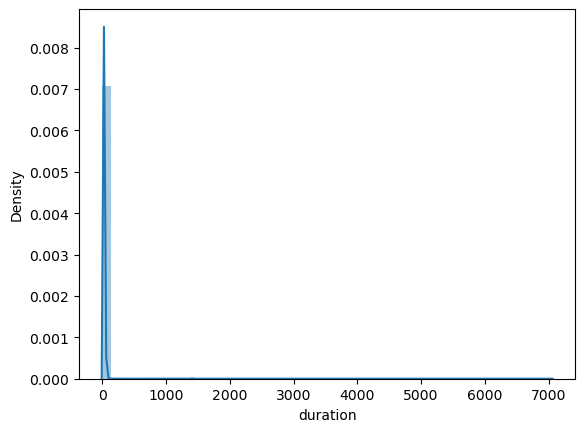

In [71]:
sns.distplot(df['duration'])

In [107]:
display(df['duration'].describe(percentiles=[.95, .98, .99]))
display(df['DOLocationID'].describe())

count    2.913679e+06
mean     1.601750e+01
std      4.284381e+01
min      0.000000e+00
50%      1.180000e+01
95%      3.721667e+01
98%      4.990000e+01
99%      5.886667e+01
max      7.053617e+03
Name: duration, dtype: float64

count    2.913679e+06
mean     1.642351e+02
std      6.975282e+01
min      1.000000e+00
25%      1.130000e+02
50%      1.620000e+02
75%      2.340000e+02
max      2.650000e+02
Name: DOLocationID, dtype: float64

In [73]:
df.drop(df.loc[df.duration < 0].index, inplace=True)

In [90]:
df_filtered = df[(df.duration > 1) & (df.duration <= 60)].copy()

In [91]:
df_filtered.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          75067
trip_distance                0
RatecodeID               75067
store_and_fwd_flag       75067
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     75067
Airport_fee              75067
duration                     0
dtype: int64

In [108]:
df_filtered['DO_PU'] = df_filtered['PULocationID'] + '_' + df_filtered['PULocationID']

In [122]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [123]:
df_filtered[categorical] = df_filtered[categorical].astype(str)

In [124]:
train_dicts = df_filtered[categorical + numerical].to_dict(orient='records')

In [128]:
dv = DictVectorizer()

In [129]:
X_train = dv.fit_transform(train_dicts)

In [132]:
X_train

<2855630x515 sparse matrix of type '<class 'numpy.float64'>'
	with 8566890 stored elements in Compressed Sparse Row format>

In [133]:
df_filtered['duration']

0           1.683333
3          32.083333
4          13.300000
5          14.633333
6          27.950000
             ...    
2913950    19.000000
2913951    11.133333
2913952    14.000000
2913953     7.000000
2913954     9.800000
Name: duration, Length: 2855630, dtype: float64

In [134]:
y_train = df_filtered['duration'].values

In [135]:
y_train

array([ 1.68333333, 32.08333333, 13.3       , ..., 14.        ,
        7.        ,  9.8       ])

In [136]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [137]:
y_pred = lr.predict(X_train)

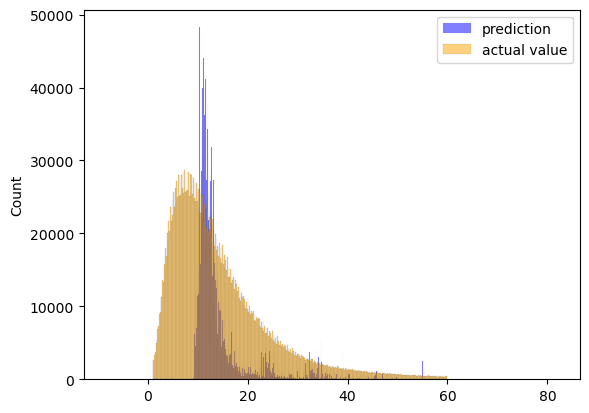

In [138]:
# sns.displot(y_pred, label='prediction')
# sns.displot(y_train, label='actual value')
# plt.legend()
# plt.show()
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.5)
sns.histplot(y_train, label='actual value', color='orange', alpha=0.5)
plt.legend()

plt.show()

In [139]:
mean_squared_error(y_train, y_pred, squared=False)

7.7861822953794775

In [141]:
with open('../models/linear_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)